In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr

from utils.simdata import email_collections

df = email_collections()

In [2]:
# financial services
# money lenders
# we want payments from our customers
# treatment = email
# outcome = payments
# payments ~ email
# we hope to see that payment goes up as a function of having received an email
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   payments      5000 non-null   int64  
 1   email         5000 non-null   int64  
 2   opened        5000 non-null   float64
 3   agreement     5000 non-null   float64
 4   credit_limit  5000 non-null   float64
 5   risk_score    5000 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 234.5 KB


In [3]:
# experiment to test the effect of receiving an email
# using random assignment we choose roughly half of customers

df['email'].value_counts()

email
0    2546
1    2454
Name: count, dtype: int64

In [ ]:
# why is random assignment so important in causal inference?
# it helps us avoid bias

# measuring the treatment effect (email, T, X)

# individual treatment effect
# person i
# prior to assignment of the treatment
# there's a world where they get the treatment
# and a world where they don't 
# payment_0i = how much person i pays, in a world where they don't receive treatment
# payment_1i = how much person i pays, in a world where they do receive treatment

# payment_1i - payment_0i
# we can't calculate the individual treatment effect, because its impossible to observe states for a single person

# what we can calculate 

# avg( payments | email) - avg(payments | no email)

# in order for this to not be biased, we need the treatment/control to be roughly "the same"

# payments_0 = payments under NO email

# avg(payments_0 | email) - avg(payments_0 | no email)

# random assignment, basically takes care of this, it helps us feel good that the groups are comparable

In [14]:
# payments ~ email

result = smf.ols("payments ~ email",data = df).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,669.9764,2.061,325.116,0.000,665.937,674.016
email,-0.6203,2.941,-0.211,0.833,-6.387,5.146


In [ ]:
# the effect of email, seems to be zero
#
# avg(payments | email = 1) = 669 -.6203*1
# avg(payments | email = 0) = 669

<Axes: xlabel='email', ylabel='payments'>

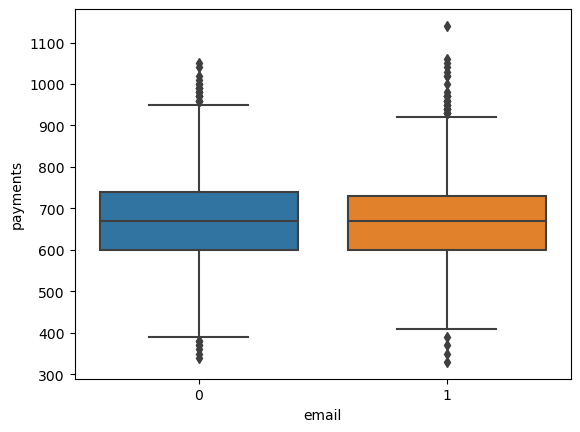

In [15]:
import seaborn as sns

sns.boxplot(x = 'email',y = 'payments', data = df)

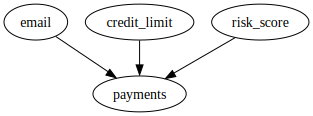

In [18]:
# if you have variables that are not correlated with the treatment
# but are correlated with the outcome
# it's totally fine, and even encouraged, to use them in your regression
# they will help explain away the variability in your outcome, that is NOT due to your treatment
# making it easier to isolate the true effect of your treatment

# directed acyclic graph (DAG)
# helps us think about the relationships

g = gr.Digraph()

g.edge("email","payments")
g.edge("credit_limit","payments")
g.edge("risk_score","payments")
g

In [19]:
result = smf.ols("payments ~ email + credit_limit + risk_score",data = df).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,490.8653,9.715,50.527,0.000,471.820,509.911
email,4.4304,2.130,2.080,0.038,0.255,8.606
credit_limit,0.1511,0.008,18.833,0.000,0.135,0.167
risk_score,-8.0516,38.424,-0.210,0.834,-83.379,67.276


In [20]:
# how are the results different compared to the first regression?
# so the effect of email has been "uncovered"

# observation: we added variables to our regression, and it became better
# implication (maybe): adding more variables to regressions is always better

# wrong

# 

result = smf.ols("payments ~ email + credit_limit + risk_score + opened + agreement",data = df).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,488.4416,9.716,50.272,0.000,469.394,507.489
email,-1.6095,2.724,-0.591,0.555,-6.949,3.730
credit_limit,0.1507,0.008,18.809,0.000,0.135,0.166
risk_score,-2.0929,38.375,-0.055,0.957,-77.325,73.139
opened,3.9808,3.914,1.017,0.309,-3.692,11.654
agreement,11.7093,4.166,2.811,0.005,3.542,19.876


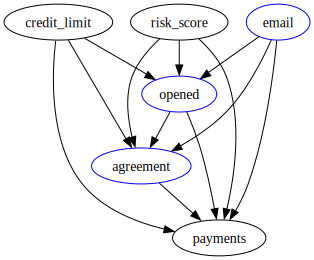

In [30]:
# observations
# email loses signficance 
# what happened?

# using our common sense
# life experience
# how do the variables that we have - relate to eachother

g = gr.Digraph()

g.edge("email","payments")
g.edge("credit_limit","payments")
g.edge("risk_score","payments")
g.edge("email","opened")
g.edge("opened","agreement")
g.edge("agreement","payments")
g.edge("risk_score","opened")
g.edge("credit_limit","opened")
g.edge("opened","payments")
g.edge("risk_score","agreement")
g.edge("credit_limit","agreement")
g.edge("email","agreement")

#color
g.node("email",color = "blue")
g.node("opened",color = "blue")
g.node("agreement",color = "blue")
g

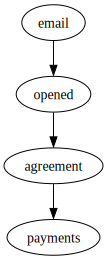

In [31]:
g = gr.Digraph()
g.edge("email","opened")
g.edge("opened","agreement")
g.edge("agreement","payments")
g

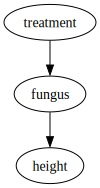

In [32]:
# SELECTION BIAS
# is when you condition on variables that are on the causal path between treatment and outcome


# what is the effect of email when holding opened and agreement fixed?
# how much additional information about payments do i learn from email, if I already know opened and agreement?

# are these the questions we wanted to answer?

# no -- these are NOT the questions we wanted to answer

# we could argue that email increases payments PRECISELY BECAUSE it increases agreements
# so we don't want to hold agreements fixed

# we should see some more examples of selection bias

# suppose you have plants
# if i use anti-fungal on my plants, will they grow taller
# plant height ~ anti-fungal treatment
# height, treated (1/0), fungus (1/0)

# if you make the following regression:

# plant height ~ treatment + fungus

# you have introduced selection bias
# post-treatment bias (selection bias)
# why?

g = gr.Digraph()
g.edge("treatment","fungus")
g.edge("fungus","height")
g

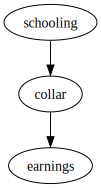

In [33]:
# another example

# you want to measure the effect of schooling on earnings
# you also include a variable that tells you if the person is a blue collar worker or white collar worker

g = gr.Digraph()
g.edge("schooling","collar")
g.edge("collar","earnings")
g

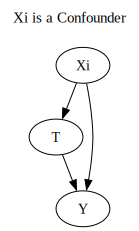

In [42]:
# guidance about what variables to include and what not to include

# Y is your outcome variable
# T is your treatment variable
# X1, ..., XN are other variables that may or not be related to Y and T

# if Xi is related to Y and to T you should include it

g = gr.Digraph()
g.attr(label='Xi is a Confounder\n\n', labelloc='t', fontsize='15')
g.edge("T","Y")
g.edge("Xi","Y")
g.edge("Xi","T")
g

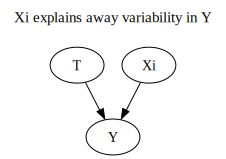

In [43]:
# Y is your outcome variable
# T is your treatment variable
# X1, ..., XN are other variables that may or not be related to Y and T

# if Xi is related to Y but not to T, you should include it

g = gr.Digraph()
g.attr(label='Xi explains away variability in Y\n\n', labelloc='t', fontsize='15')
g.edge("T","Y")
g.edge("Xi","Y")
g

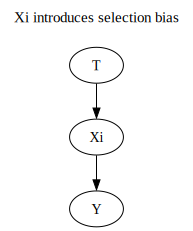

In [46]:
# Y is your outcome variable
# T is your treatment variable
# X1, ..., XN are other variables that may or not be related to Y and T

# if Xi is related to T but and to Y (but only through T), you should not include it

g = gr.Digraph()
g.attr(label='Xi introduces selection bias\n\n', labelloc='t', fontsize='15')
g.edge("T","Xi")
g.edge("Xi","Y")
g

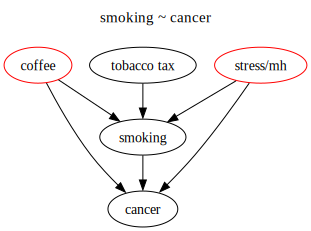

In [53]:
# instrumental variables
# in cases where we have "omitted variables"

g = gr.Digraph()
g.attr(label='smoking ~ cancer\n\n', labelloc='t', fontsize='15')
g.edge("smoking","cancer")
g.edge("coffee","cancer")
g.edge("coffee","smoking")
g.edge("stress/mh","cancer")
g.edge("stress/mh","smoking")
g.edge("tobacco tax", "smoking")
g.node("coffee",color="red")
g.node("stress/mh",color="red")
g

In [ ]:
# an instrumental variable
# is something that influences the treatment, but is not related (at all, causally) to the outcome

# tobacco tax would be a good instrumental variable in this case

# tobacco tax should actually be related to smoking
# we have to show that they move together, if tax rate goes up, smoking goes down - plausible causal relationship 
# tobacco tax is not related to cancer - you can argue that there is no way

# how do you actually use the instrument?
# you do a two stage linear regression

# stage 1
# smoking ~ tax rate
# predicted_smoking

# stage 2
# cancer ~ predicted_smoking

# coefficient for predicted_smoking in stage 2, is the estimated causal effect of smoking on cancer

